In [1]:
import openmc
import numpy as np

In [2]:
# Create materials
fuel = openmc.Material(name='fuel')
fuel.set_density('g/cm3', density=3.35)
fuel.add_components({'Li7': 0.0787474673879085,
                  'Be9': 0.0225566879138321,
                  'F19': 0.454003012179284,
                  'Th232': 0.435579130482336,
                  'U233': 0.00911370203663893},
                 percent_type='wo')
fuel.depletable = True
fuel.volume = 48710000.0

moder = openmc.Material(name='graphite', temperature=900.0)
moder.set_density('g/cm3', density=1.84)
moder.add_nuclide('C0', 1.000, percent_type='wo')
moder.add_s_alpha_beta('c_Graphite')

hast = openmc.Material(name='hastelloyN', temperature=900.0)
hast.set_density('g/cm3', density=8.671)
hast.add_components({'Al27': 0.003,
                  'Ni': 0.677,
                  'W': 0.250,
                  'Cr': 0.070},
                 percent_type='wo')

mat = openmc.Materials(materials=[fuel, moder, hast])
mat.export_to_xml()

In [3]:
colormap = {moder: 'purple',
            hast: 'blue',
            fuel: 'yellow'}

In [65]:
 def _bound_zone_cells(cells_tuples, levels):
    """Helper function that moves Zone IA and Zone IIA cells to the
    appropriate height."""
    cell_list = []
    n_levels = len(cells_tuples)
    for i, cells in enumerate(cells_tuples):
        if i == 0:
            lower_bound = None
            upper_bound = levels[i]
        elif i == n_levels - 1:
            lower_bound = levels[i-1]
            upper_bound = None
        else:
            lower_bound = levels[i-1]
            upper_bound = levels[i]
        for j, cell in enumerate(cells):
            if lower_bound is None:
                cell.region = cell.region & -upper_bound
            elif upper_bound is None:
                cell.region = cell.region & +lower_bound
            else:
                cell.region = cell.region & +lower_bound & -upper_bound
            cell_list.append(cell)
    return cell_list

def shared_elem_geometry(elem_type, eb_d, gr_sq_d, gr_sq_r, r_dt, l1, l2, l3, r_es, es_name):
    """Surfaces and regions shared by Zone IA and Zone IIA elements.
    Specs found in Robertson, 1971 Fig 3.4 (p. 17) and Fig 3.5 (p.18)"""
    elem_bound = openmc.rectangular_prism(eb_d*2, eb_d*2) # Pin outer boundary
    eb_minx, eb_maxx, eb_miny, eb_maxy = list(elem_bound.get_surfaces().values())

    gr_sq_neg = openmc.rectangular_prism(gr_sq_d*2, gr_sq_d*2, corner_radius=gr_sq_r) # Graphite square
    (gr_minx, gr_maxx, gr_miny, gr_maxy,
    gr_cyl_lb, gr_cyl_minx, gr_cyl_miny,
    gr_cyl_ul, gr_cyl_maxy, gr_cyl_br,
    gr_cyl_maxx, gr_cyl_ru) = list(gr_sq_neg.get_surfaces().values())

    # remaining square
    gr_sq_neg = +gr_minx & -gr_maxx & +gr_cyl_miny & -gr_cyl_maxy

    ul_t = openmc.ZCylinder(-l1, -l3, r_dt, name='corner_ul_tip')
    br_t = openmc.ZCylinder(l1, l3, r_dt, name='corner_br_tip')
    ru_t = openmc.ZCylinder(-l3, l1, r_dt, name='corner_ru_tip')
    lb_t = openmc.ZCylinder(l3, -l1, r_dt, name='corner_lb_tip')

    if elem_type == 'core':
        # for main pin section for both I-A and II-A
        ul = openmc.ZCylinder(-l1, l2, r_dt, name='corner_ul')
        br = openmc.ZCylinder(l1, -l2, r_dt, name='corner_br')
        lb = openmc.ZCylinder(-l2, -l1, r_dt, name='corner_lb')
        ru = openmc.ZCylinder(l2, l1, r_dt, name='corner_ru')

        # corner regions
        gr_ul = -ul & +gr_maxy
        gr_ul_fill = -ul & +gr_cyl_ul & -gr_maxy & -gr_cyl_minx & +gr_cyl_maxy
        gr_br = -br & -gr_miny
        gr_br_fill = -br & +gr_cyl_br & +gr_miny & +gr_cyl_maxx & -gr_cyl_miny
        gr_lb = -lb & -gr_minx
        gr_lb_fill = -lb & +gr_cyl_lb & +gr_minx & -gr_cyl_minx & -gr_cyl_miny
        gr_ru = -ru & +gr_maxx
        gr_ru_fill = -ru & +gr_cyl_ru & -gr_maxx & +gr_cyl_maxx & +gr_cyl_maxy

        # inter-element channel regions
        iec_r = +gr_cyl_miny & -gr_cyl_maxy & +gr_maxx & +lb_t & +ru & +gr_cyl_ru
        iec_ru = (+gr_cyl_ru & +gr_cyl_maxx & +gr_cyl_maxy) & +ru & +br_t
        iec_u = +gr_cyl_minx & -gr_cyl_maxx & +gr_maxy & +br_t & +ul & +gr_cyl_ul
        iec_ul = (+gr_cyl_ul & -gr_cyl_minx & +gr_cyl_maxy) & +ul & +ru_t
        iec_l = +gr_cyl_miny & -gr_cyl_maxy & -gr_minx & +ru_t & +lb & +gr_cyl_lb
        iec_lb = (+gr_cyl_lb & -gr_cyl_minx & -gr_cyl_miny) & +lb & +ul_t
        iec_b = +gr_cyl_minx & -gr_cyl_maxx & -gr_miny & +ul_t & +br & +gr_cyl_br
        iec_br = (+gr_cyl_br & +gr_cyl_maxx & -gr_cyl_miny) & +br & +lb_t
        
        inter_elem_channel = [[iec_r, 'outer_r'], [iec_ru, 'outer_ru'],
                              [iec_u, 'outer_u'], [iec_ul, 'outer_ul'],
                              [iec_l, 'outer_l'], [iec_lb, 'outer_lb'],
                              [iec_b, 'outer_b'], [iec_br, 'outer_br']]

    elif elem_type == 'cr':
        # params for control rods
        r_d = 1.16
        e_d = 2 * r_d / np.sqrt(3)
        r_c = 0.18

        ul = openmc.model.hexagonal_prism(origin=(-l1, l2), edge_length=e_d, orientation='x', corner_radius=r_c)
        br = openmc.model.hexagonal_prism(origin=(l1, -l2), edge_length=e_d, orientation='x',corner_radius=r_c)
        lb = openmc.model.hexagonal_prism(origin=(-l2, -l1), edge_length=e_d, orientation='y',corner_radius=r_c)
        ru = openmc.model.hexagonal_prism(origin=(l2, l1), edge_length=e_d, orientation='y',corner_radius=r_c)

        (ul_u, ul_b, ul_ur, ul_br, ul_bl, ul_ul,
         ul_cyl_bl_in, ul_cyl_bl_out,
         ul_cyl_ul_in, ul_cyl_ul_out,
         ul_cyl_br_in, ul_cyl_br_out,
         ul_cyl_ur_in, ul_cyl_ur_out,
         ul_cyl_l_in, ul_cyl_l_out,
         ul_cyl_r_in, ul_cyl_r_out)= list(ul.get_surfaces().values())
        (br_u, br_b, br_ur, br_br, br_bl, br_ul,
         br_cyl_bl_in, br_cyl_bl_out,
         br_cyl_ul_in, br_cyl_ul_out,
         br_cyl_br_in, br_cyl_br_out,
         br_cyl_ur_in, br_cyl_ur_out,
         br_cyl_l_in, br_cyl_l_out,
         br_cyl_r_in, br_cyl_r_out)= list(br.get_surfaces().values())
        (lb_r, lb_l, lb_ur, lb_ul, lb_br, lb_bl,
         lb_cyl_lb_in, lb_cyl_lb_out,
         lb_cyl_lu_in, lb_cyl_lu_out,
         lb_cyl_rb_in, lb_cyl_rb_out,
         lb_cyl_ru_in, lb_cyl_ru_out,
         lb_cyl_b_in, lb_cyl_b_out,
         lb_cyl_u_in, lb_cyl_u_out)= list(lb.get_surfaces().values())
        (ru_r, ru_l, ru_ur, ru_ul, ru_br, ru_bl,
         ru_cyl_lb_in, ru_cyl_lb_out,
         ru_cyl_lu_in, ru_cyl_lu_out,
         ru_cyl_rb_in, ru_cyl_rb_out,
         ru_cyl_ru_in, ru_cyl_ru_out,
         ru_cyl_b_in, ru_cyl_b_out,
         ru_cyl_u_in, ru_cyl_u_out)= list(ru.get_surfaces().values())

        # corner regions
        gr_ul = -ul_ul & -ul_ur & +gr_maxy
        gr_ul_fill = -ul_ul & +ul_bl & +ul_cyl_l_out & +gr_cyl_ul & -gr_maxy & -gr_cyl_minx & +gr_cyl_maxy
        gr_lb = +lb_bl & -lb_ul & -gr_minx
        gr_lb_fill = +lb_bl & +lb_br & +lb_cyl_b_out & +gr_cyl_lb & +gr_minx & -gr_cyl_miny & -gr_cyl_minx
        gr_br = +br_br & +br_bl & -gr_miny
        gr_br_fill = +br_br & -br_ur & +br_cyl_r_out & +gr_cyl_br & +gr_miny & +gr_cyl_maxx & -gr_cyl_miny
        gr_ru = +ru_br & -ru_ur & +gr_maxx
        gr_ru_fill = -ru_ur & -ru_ul & +ru_cyl_u_out & +gr_cyl_ru & -gr_maxx & +gr_cyl_maxy & +gr_cyl_maxx

        # inter-element channel regions
        iec_r = +gr_cyl_miny & +gr_maxx & +lb_t & -ru_br
        iec_ru_main = +gr_cyl_ru & (+ru_ur) & +br_t
        iec_ru_fill1 = +gr_cyl_ru & +gr_cyl_maxx & (+ru_ul & -ru_ur) & +br_t
        iec_ru_fill2 = +gr_cyl_ru & ((-ru_cyl_u_out)) & -ru_ul & -ru_ur
        iec_u = -gr_cyl_maxx & +gr_maxy & +br_t & +ul_ur
        iec_ul_main = +gr_cyl_ul & (+ul_ul) & +ru_t
        iec_ul_fill1 = +gr_cyl_ul & +gr_cyl_maxy & (-ul_bl & -ul_ul) & +ru_t
        iec_ul_fill2 = +gr_cyl_ul & ((-ul_cyl_l_out)) & +ul_bl & -ul_ul
        iec_l = -gr_cyl_maxy & -gr_minx & +ru_t & +lb_ul
        iec_lb_main = +gr_cyl_lb & (-lb_bl) & +ul_t
        iec_lb_fill1 = +gr_cyl_lb & -gr_cyl_minx & (-lb_br & +lb_bl) & +ul_t
        iec_lb_fill2 = +gr_cyl_lb & ((-lb_cyl_b_out)) & +lb_br & +lb_bl
        iec_b = +gr_cyl_minx & -gr_miny & +ul_t & -br_bl
        iec_br_main = +gr_cyl_br & (-br_br) & +lb_t
        iec_br_fill1 = +gr_cyl_br & -gr_cyl_miny & (+br_ur & +br_br) & +lb_t
        iec_br_fill2 = +gr_cyl_br & ((-br_cyl_r_out)) & -br_ur & +br_br
        
        inter_elem_channel = [[iec_r, 'outer_r'], [iec_ru_main, 'outer_ru_main'],
                              [iec_ru_fill1, 'outer_ru_fill1'], [iec_ru_fill2, 'outer_ru_fill2'],
                              [iec_u, 'outer_u'], [iec_ul_main, 'outer_ul_main'],
                              [iec_ul_fill1, 'outer_ul_fill1'], [iec_ul_fill2, 'outer_ul_fill2'],
                              [iec_l, 'outer_l'], [iec_lb_main, 'outer_lb_main'],
                              [iec_lb_fill1, 'outer_lb_fill1'], [iec_lb_fill2, 'outer_lb_fill2'],
                              [iec_b, 'outer_b'], [iec_br_main, 'outer_br_main'],
                              [iec_br_fill1, 'outer_br_fill1'], [iec_br_fill2, 'outer_br_fill2']]

    # shared corner regions
    gr_ul_t = -ul_t
    gr_br_t = -br_t
    gr_ru_t = -ru_t
    gr_lb_t = -lb_t

    gr_corners = [[gr_ul, 'ul'], [gr_br, 'br'],  [gr_ru, 'ru'], [gr_lb, 'lb'],
                  [gr_ul_t, 'ul_t'], [gr_br_t, 'br_t'], [gr_ru_t, 'ru_t'], [gr_lb_t, 'lb_t'],
                  [gr_ul_fill, 'ul_fill'], [gr_br_fill, 'br_fill'], [gr_ru_fill, 'ru_fill'], [gr_lb_fill, 'lb_fill']]

    # slabs that line up with rounded edges
    slab_u = -gr_maxy & +gr_cyl_maxy & -gr_cyl_maxx & +gr_cyl_minx
    #slab_l = +gr_minx & -gr_cyl_minx & -gr_cyl_maxy & +gr_cyl_miny
    slab_b = +gr_miny & -gr_cyl_miny & -gr_cyl_maxx & +gr_cyl_minx
    #slab_r = -gr_maxx & +gr_cyl_maxx & -gr_cyl_maxy & +gr_cyl_miny
    slabs = [[slab_u, 'slab_u'], 
             #[slab_l, 'slab_l'], 
             [slab_b, 'slab_b']]#, 
             #[slab_r, 'slab_r']]

    # the rounded edges themselves
    quarter_ul = -gr_cyl_ul & -gr_cyl_minx & +gr_cyl_maxy
    quarter_br = -gr_cyl_br & +gr_cyl_maxx & -gr_cyl_miny
    quarter_lb = -gr_cyl_lb & -gr_cyl_minx & -gr_cyl_miny
    quarter_ru = -gr_cyl_ru & +gr_cyl_maxx & +gr_cyl_maxy
    quarters = [[quarter_ul, 'quarter_ul'], [quarter_br, 'quarter_br'],  [quarter_ru, 'quarter_ru'], [quarter_lb, 'quarter_lb']]

    gr_reg = gr_corners + slabs + quarters

    extra_surf = openmc.ZCylinder(r=r_es, name=es_name)


    return elem_bound, gr_sq_neg, gr_reg, inter_elem_channel, extra_surf         

In [53]:
def zoneIA(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4):
    """Zone IA element. Specs found in Robertson, 1971 Fig 3.4 (p. 17)"""
    elem_levels = [22.86, 419.10, 438.15, 445.135]
    level_bounds = []
    for level in elem_levels:
        level_bounds.append(openmc.ZPlane(z0=level))
    s1 = openmc.ZCylinder(r=4.953, name='ia_gr_round_1')
    s2 = openmc.ZCylinder(r=1.71069, name='ia_fuel_hole')

    h = 12.66
    theta = np.arctan(4.953 / h)
    r2 = (1 / np.cos(theta))**2 - 1
    s3 = openmc.ZCone(z0=h + elem_levels[2], r2=r2, name='cone_i')

    c1 = openmc.Cell(fill=fuel, region=(-s2), name='ia_fuel_inner_1')
    c2 = openmc.Cell(fill=moder, region=(+s2 & -s1), name='ia_moderator_1')
    c3 = openmc.Cell(fill=fuel, region=(+s1), name='ia_fuel_outer_1')
    ia1 = (c1, c2, c3)

    # I-A  main (lower 2)
    s2 = s2.clone()
    c4 = c1.clone(clone_materials=False)
    c4.name = 'ia_fuel_inner_main'
    c5 = openmc.Cell(fill=moder, region=(+s2 & gr_sq_neg), name='ia_moderator_main_core')
    iam = [c4, c5]
    for (reg, name) in gr_corners:
        iam.append(openmc.Cell(fill=moder, region=reg, name=f'ia_moderator_main_{name}'))
    for (reg, name) in inter_elem_channel:
        iam.append(openmc.Cell(fill=fuel, region=reg, name=f'ia_fuel_outer_main_{name}'))

    # I-A 2 (upper 1)
    c7 = c1.clone(clone_materials=False)
    c7.name = 'ia_fuel_inner_2'
    c8 = c2.clone(clone_materials=False)
    c8.name = 'ia_moderator_2'
    c9 = c3.clone(clone_materials=False)
    c9.name = 'ia_fuel_outer_2'
    ia2 = (c7, c8, c9)

    # I-A 3 (upper 2)'
    s2 = s2.clone()
    s3 = s3.clone()
    #elem_bound = elem_bound.clone()
    c10 = c1.clone(clone_materials=False)
    c10.name = 'ia_fuel_inner_3'
    c11 = openmc.Cell(fill=moder, region=(+s2 & -s3), name='ia_moderator_3')
    c12 = openmc.Cell(fill=fuel, region=(+s3), name='ia_fuel_outer_3')
    ia3 = (c10, c11, c12)

    # I-A 4 (upper 3)
    s2 = s2.clone()
    #elem_bound = elem_bound.clone()
    c13 = openmc.Cell(fill=hast, region=(-s2), name='ia_hast')
    c14 = openmc.Cell(fill=moder, region=(+s2 & -gr_round_4), name='ia_moderator_4')
    c15 = openmc.Cell(fill=fuel, region=(+gr_round_4), name='ia_fuel_outer_4')
    ia4 = (c13, c14, c15)

    elem_cells = [ia1, iam, ia2, ia3, ia4]
    # universe_id=1
    ia = openmc.Universe(name='zone_ia')
    ia.add_cells(_bound_zone_cells(elem_cells, level_bounds))
    return ia

def zoneIIA(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4):
    """Zone IIA element. Specs found in Robertson, 1971 Fig 3.5 (p. 18)"""
    elem_levels = [434.34, 436.88, 439.42, 441.96]
    level_bounds = []
    for level in elem_levels:
        level_bounds.append(openmc.ZPlane(z0=level))
    s1 = openmc.ZCylinder(r=3.302, name='iia_fuel_hole_main') # Hole with fuel salt - Fig 3.5, Roberton 1971 (3.27787 - p.47)
    s2 = openmc.ZCylinder(r=0.635, name='iia_fuel_hole_2')
    s3 = openmc.ZCylinder(r=3.65125, name='iia_gr_round_3')
    h = 6.5
    theta = np.arctan(3.65125 / h)
    r2 = (1 / np.cos(theta))**2 - 1
    s4 = openmc.ZCone(z0=h + elem_levels[2], r2=r2, name='cone_ii')

    # II-A main (lower 1)
    c1 = openmc.Cell(fill=fuel, region=(-s1), name='iia_fuel_inner_main')
    c2 = openmc.Cell(fill=moder, region=(+s1 & gr_sq_neg), name='iia_moderator_main_core')
    iiam = [c1, c2]

    # II-A 2 (upper 1)
    gr_sq_neg = gr_sq_neg.clone()
    c4 = openmc.Cell(fill=fuel, region=(-s2), name='iia_fuel_inner_2')
    c5 = openmc.Cell(fill=moder, region=(+s2 & gr_sq_neg), name='iia_moderator_2_core')
    iia2 = [c4, c5]

    for (reg, name) in gr_corners:
        iiam.append(openmc.Cell(fill=moder, region=reg, name=f'iia_moderator_main_{name}'))
        iia2.append(openmc.Cell(fill=moder, region=reg, name=f'iia_moderator_main_{name}'))
    for (reg, name) in inter_elem_channel:
        iiam.append(openmc.Cell(fill=fuel, region=reg, name=f'iia_fuel_outer_main_{name}'))
        iia2.append(openmc.Cell(fill=fuel, region=reg, name=f'iia_fuel_outer_2_{name}'))

    # II-A 3 (upper 2)
    s2 = s2.clone()
    #elem_bound = elem_bound.clone()
    c7 = c4.clone(clone_materials=False)
    c7.name = 'iia_fuel_inner_3'
    c8 = openmc.Cell(fill=moder, region=(+s2 & -s3), name='iia_moderator_3')
    c9 = openmc.Cell(fill=fuel, region=(+s3), name='iia_fuel_outer_3')
    iia3 = (c7, c8, c9)

    # II-A 4 (upper 3)
    #elem_bound = elem_bound.clone()
    c10 = openmc.Cell(fill=moder, region=(-s4), name='iia_moderator_4')
    c11 = openmc.Cell(fill=fuel, region=(+s4), name='iia_fuel_outer_4')
    iia4 = (c10, c11)

    # II-A 5 (upper 4)
    #elem_bound = elem_bound.clone()
    c12 = openmc.Cell(fill=moder, region=(-gr_round_4), name='iia_moderator_5')
    c13 = openmc.Cell(fill=fuel, region=(+gr_round_4), name='iia_fuel_outer_5')
    iia5 = (c12, c13)

    elem_cells = [iiam, iia2, iia3, iia4, iia5]
    # universe_id=2
    iia = openmc.Universe(name='zone_iia')
    iia.add_cells(_bound_zone_cells(elem_cells, level_bounds))
    return iia

def void_cell(elem_bound):
    #elem_bound = elem_bound.clone()
    #c1 = openmc.Cell(region=elem_bound, name='lattice_void')
    c1 = openmc.Cell(name='lattice_void')
    #universe_id=5
    v = openmc.Universe(name='lattice_void')
    v.add_cell(c1)
    return v

def graphite_triangles(elem_bound):
    s1 = openmc.Plane(1.0, 1.0, 0.0, 0.0)
    s2 = openmc.Plane(-1.0, 1.0, 0.0, 0.0)
    s3 = openmc.Plane(1.0, -1.0, 0.0, 0.0)
    s4 = openmc.Plane(-1.0, -1.0, 0.0, 0.0)
    surfs = [(s4, 'bottom_left'),
             (s1, 'top_right'),
             (s2, 'top_left'),
             (s3, 'bottom_right')]
    univs = []
    for i, (s, name) in enumerate(surfs):
        #elem_bound = elem_bound.clone()
        c1 = openmc.Cell(fill=moder, region=(-s))
        #elem_bound = elem_bound.clone()
        c2 = openmc.Cell(fill=fuel, region=(+s))
        # universe_id = 6+i
        gr_tri = openmc.Universe(name=f'{name}_triangle')
        gr_tri.add_cells([c1, c2])
        univs.append(gr_tri)
    return univs

In [54]:
#elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4 = shared_elem_geometry('core', 5.08, 4.953, 0.46, 0.66802, 4.28498, 4.53898, 5.62102, 2.2225, 'gr_round_4')
#ia = zoneIA(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4)
#iia = zoneIIA(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4)
# tres, uno, dos, quatro
#bl, ur, ul, br = graphite_triangles(elem_bound)

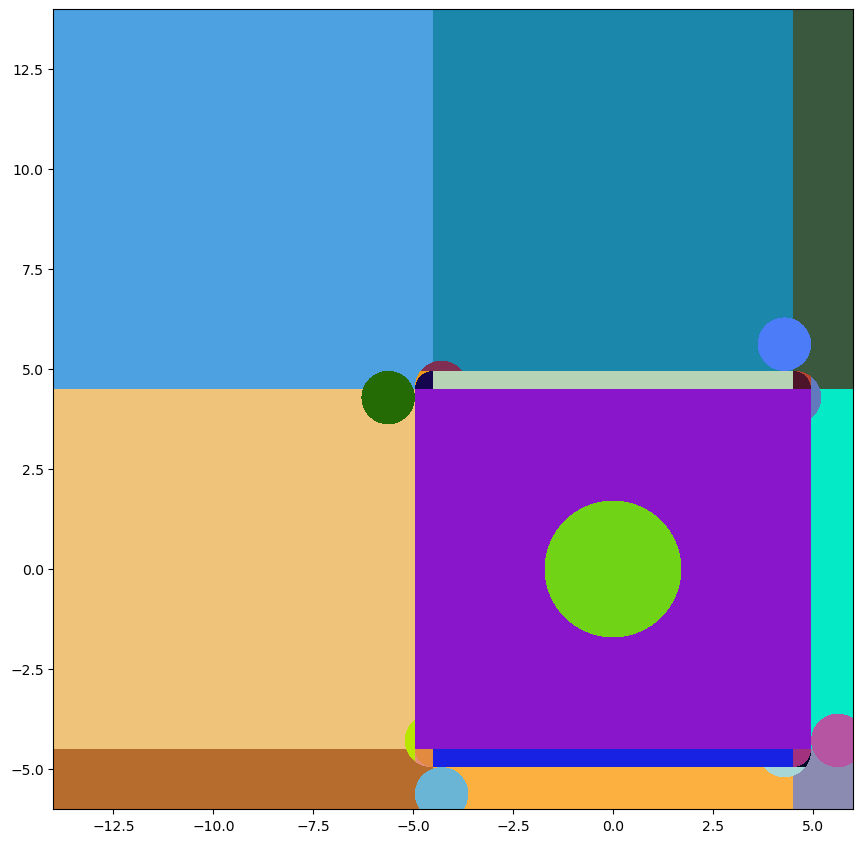

In [55]:
#ia.plot(width=(20,20),
#        basis='xy',
#        colors=colormap,
#        origin=(-4.,4., 300),
#        color_by='material',
#        pixels=(800,800))

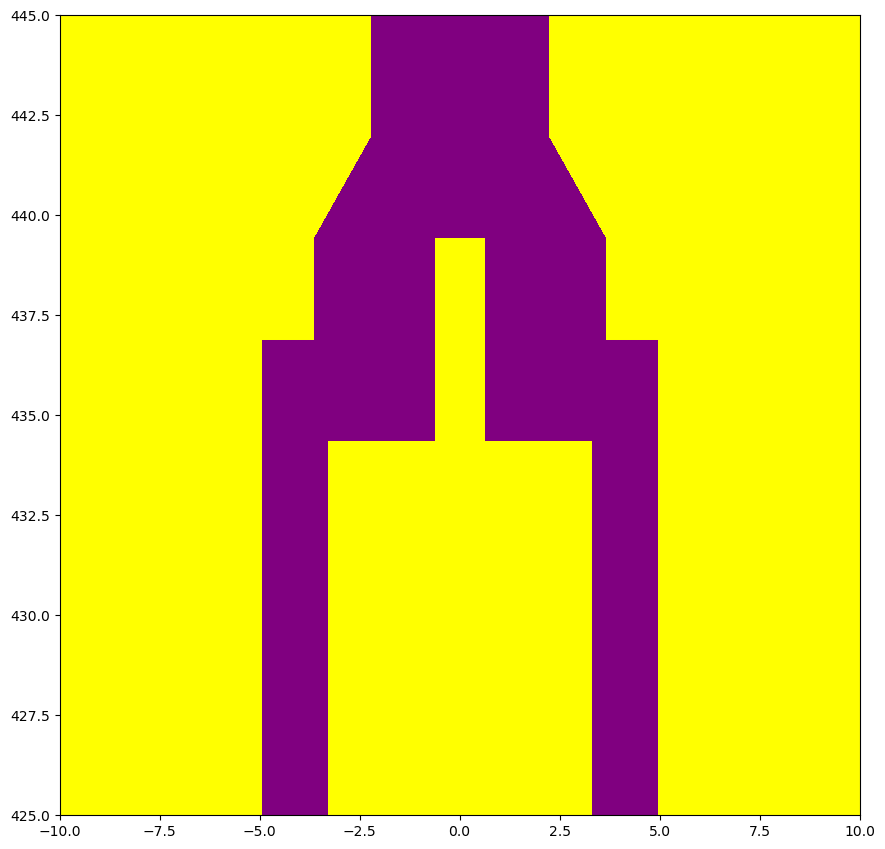

In [57]:
#iia.plot(width=(20,20),
#        basis='xz',
#        colors=colormap,
#        origin=(0.,0.,435),
#        color_by='material',
#        pixels=(800,800))

In [58]:
def control_rod(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole):
    s1 = openmc.ZCylinder(r=4.7625, name='control_rod')

    c1 = openmc.Cell(fill=moder, region=-s1, name='control_rod')
    c2 = openmc.Cell(fill=fuel, region=(+s1 & -fuel_hole), name='cr_fuel_inner')
    c3 = openmc.Cell(fill=moder, region=(+fuel_hole & gr_sq_neg), name='cr_moderator_core')

    #universe_id=3
    cr = openmc.Universe(name='control_rod', cells=[c1, c2, c3])

    for (reg, name) in gr_corners:
        cr.add_cell(openmc.Cell(fill=moder, region=reg, name=f'cr_moderator_{name}'))
    for (reg, name) in inter_elem_channel:
        cr.add_cell(openmc.Cell(fill=fuel, region=reg, name=f'cr_fuel_outer_{name}'))

    return cr

def control_rod_channel(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole):
    c1 = openmc.Cell(fill=fuel, region=(-fuel_hole), name='crc_fuel_inner')
    c2 = openmc.Cell(fill=moder, region=(+fuel_hole & gr_sq_neg), name='crc_moderator_core')

    # universe_id=4
    crc = openmc.Universe(name='control_rod_channel', cells=[c1, c2])

    for (reg, name) in gr_corners:
        crc.add_cell(openmc.Cell(fill=moder, region=reg, name=f'crc_moderator_{name}'))
    for (reg, name) in inter_elem_channel:
        crc.add_cell(openmc.Cell(fill=fuel, region=reg, name=f'crc_fuel_outer_{name}'))

    return crc

In [66]:
#elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole = shared_elem_geometry('cr', 7.62, 7.23645, 0.99, 0.8, 5.8801, 6.505, 8.03646, 5.08, 'cr_fuel_hole')

#cr = control_rod(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole)
#crc = control_rod_channel(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole)

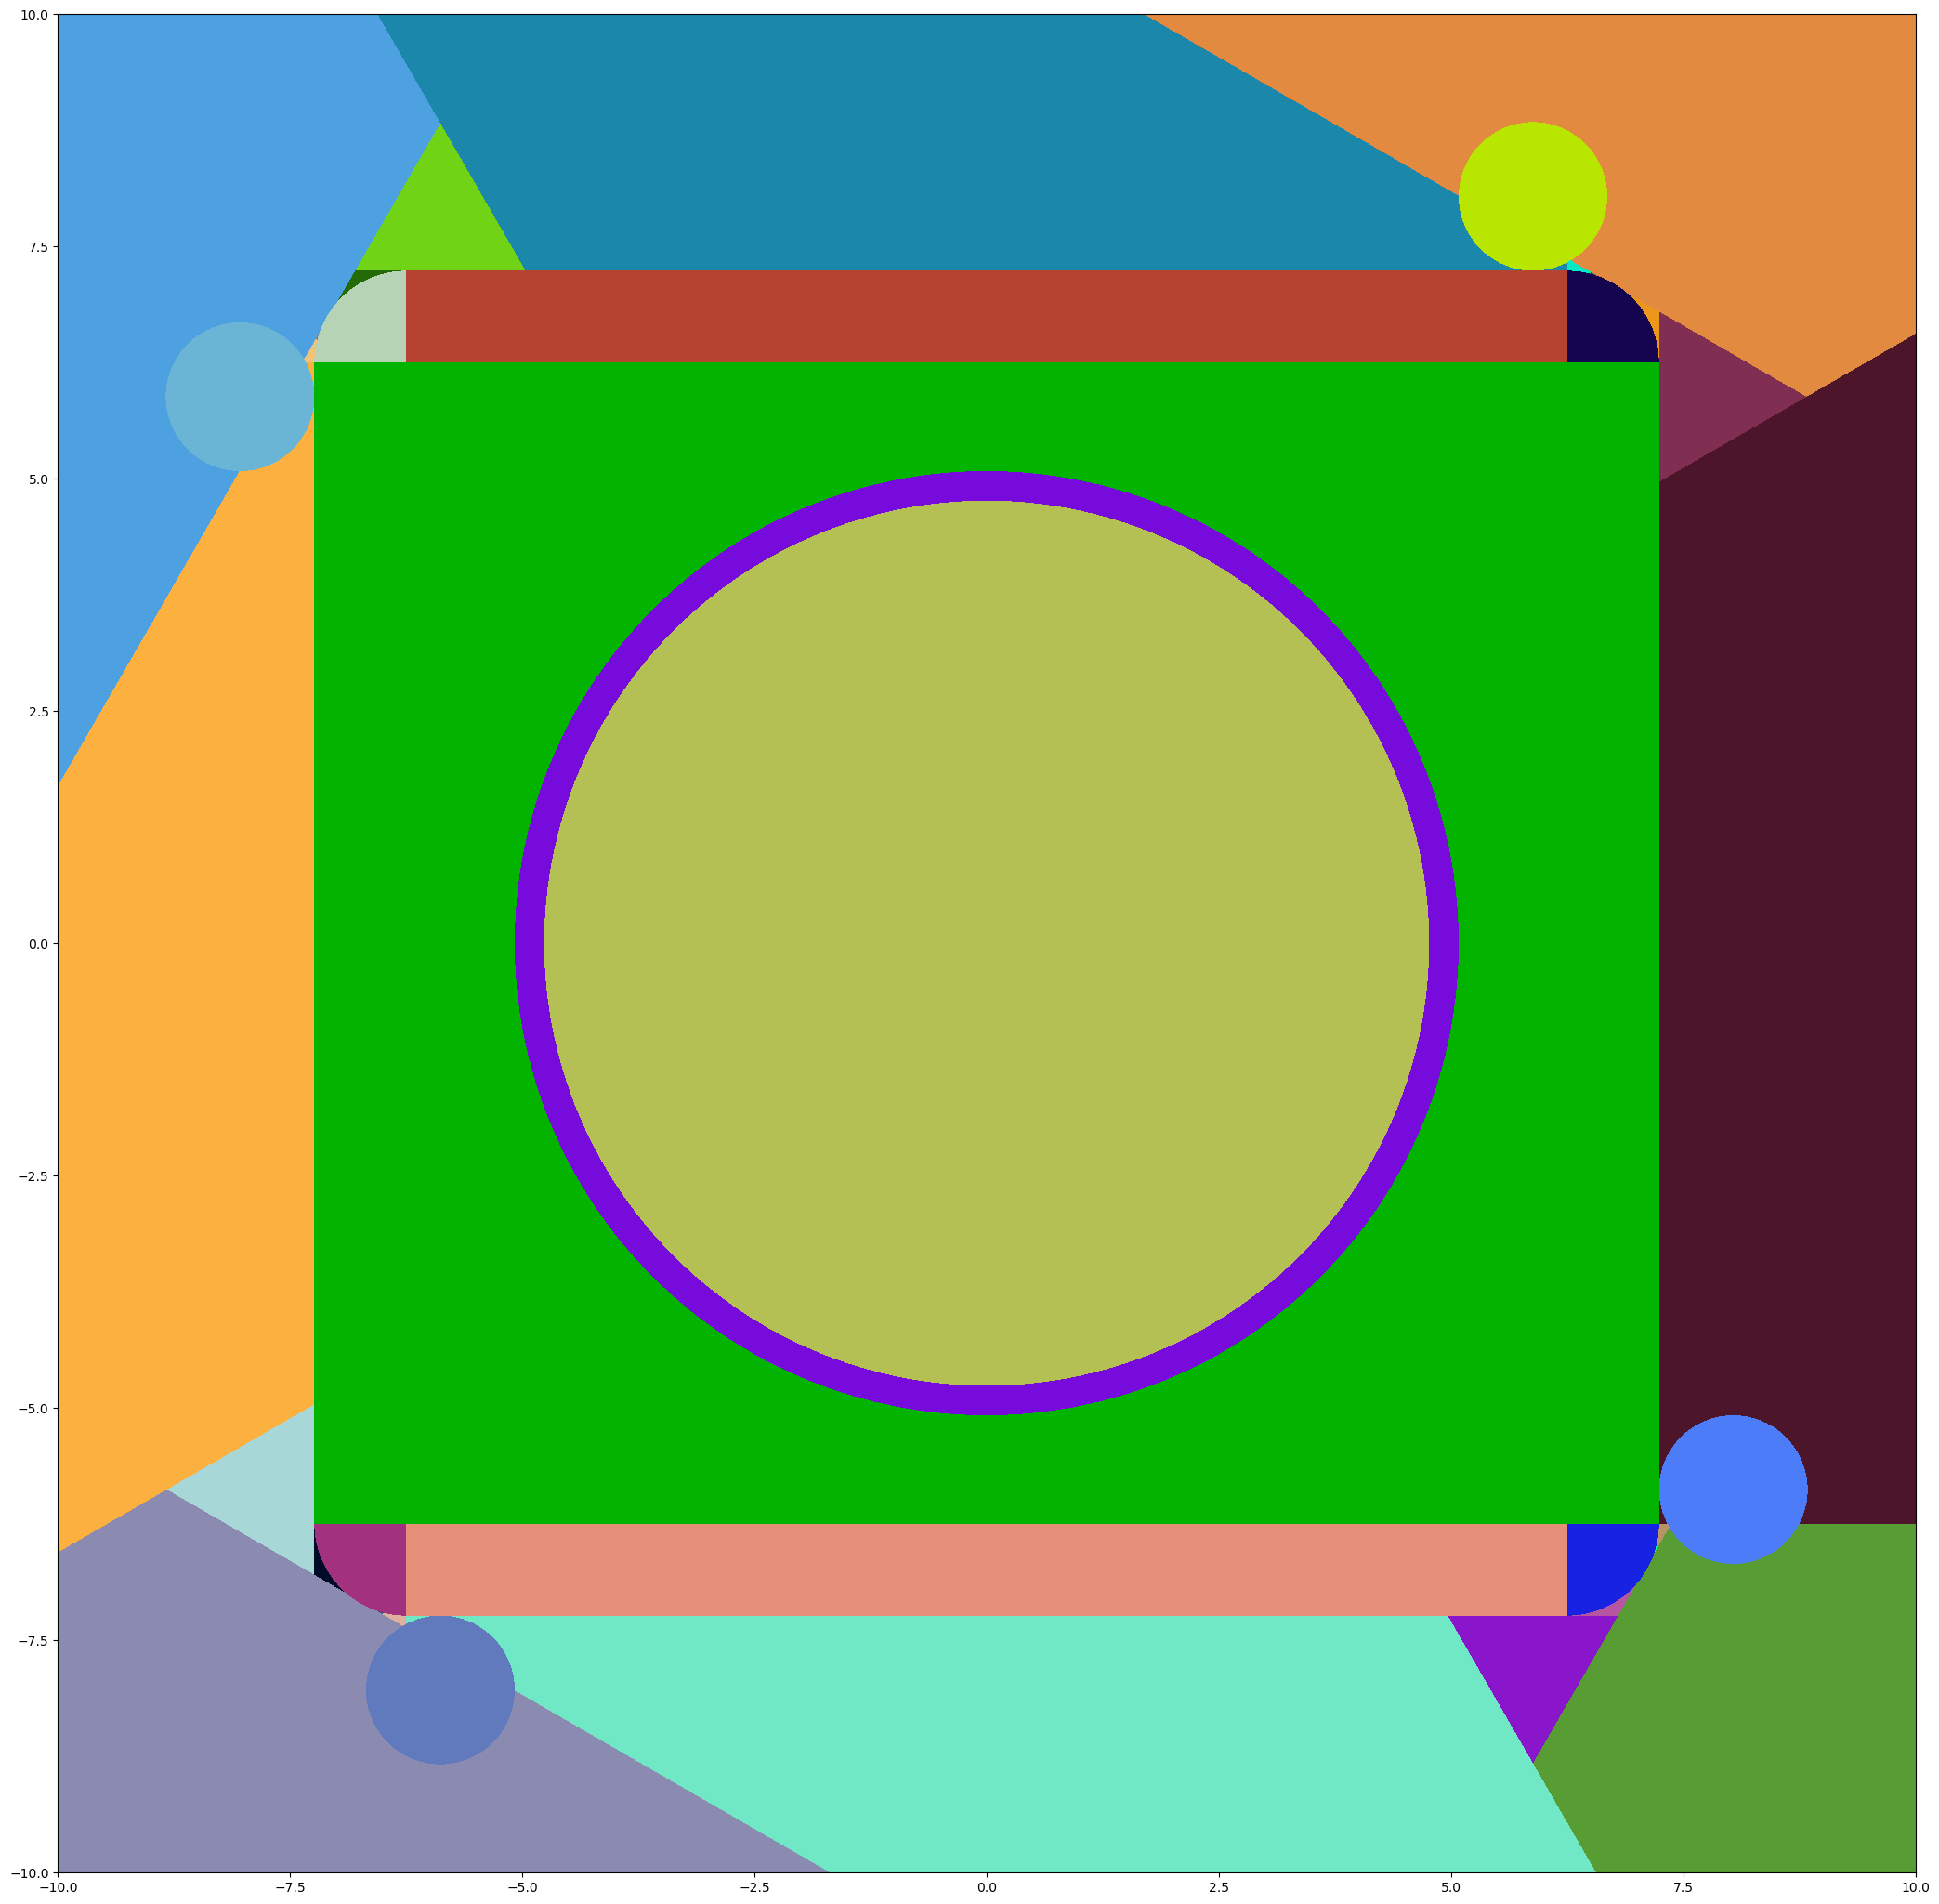

In [67]:
#cr.plot(width=(20,20),
#        basis='xy',
#        colors=colormap,
#        origin=(0.,0.,440),
#        color_by='material',
#        pixels=(2000,2000))

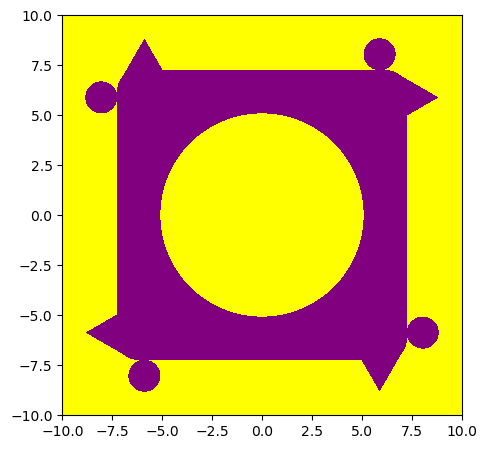

In [68]:
#crc.plot(width=(20,20),
#        basis='xy',
#        colors=colormap,
#        origin=(0.,0.,440),
#        color_by='material',
#        pixels=(400,400))

In [69]:
def shared_root_geometry():
    cr_boundary = openmc.model.rectangular_prism(15.24*2, 15.24*2)
    
    core_base = openmc.ZPlane(z0=0.0, name='core_base')
    core_top = openmc.ZPlane(z0=449.58, name='core_top')
    
    s1 = openmc.model.IsogonalOctagon(center=(0.0,0.0), r1=208.28, r2=222.71, name='base_octader')
    s2 = openmc.model.IsogonalOctagon(center=(0.0,0.0), r1=218.44, r2=215.53, name='smaller_octader')
    s3 = openmc.model.IsogonalOctagon(center=(0.0,0.0), r1=228.60, r2=193.97, name='smallest_octader')
    
    oct1 = list((-s1).get_surfaces().values())
    oct2 = list((-s2).get_surfaces().values())
    oct3 = list((-s3).get_surfaces().values())
    zone_i_octas = (oct1, oct2, oct3)
    
    zone_ii_boundary = openmc.ZCylinder(r=256.032, name='iib_boundary')
    annulus_boundary = openmc.ZCylinder(r=261.112, name='annulus_boundary')
    lower_plenum_boundary = openmc.ZPlane(z0=-7.62, name='lower_plenum_boundary')

    zone_bounds = (cr_boundary, zone_i_octas, zone_ii_boundary)
    
    core_bounds = (annulus_boundary, lower_plenum_boundary, core_base, core_top)
    
    radial_reflector_boundary = openmc.ZCylinder(r=338.328, name='radial_reflector_boundary')    
    bottom_reflector_boundary = openmc.ZPlane(z0=-76.2, name='bottom_axial_reflector_boundary')
    top_reflector_boundary = openmc.ZPlane(z0=525.78, name='top_axial_reflector_boundary') 
    
    reflector_bounds = (radial_reflector_boundary,
                        bottom_reflector_boundary,
                        top_reflector_boundary)
    
    radial_vessel_boundary = openmc.ZCylinder(r=343.408, name='radial_vessel_wall', boundary_type='vacuum')
    bottom_vessel_boundary = openmc.ZPlane(z0=-81.28, name='bottom_vessel_wall', boundary_type='vacuum')
    top_vessel_boundary = openmc.ZPlane(z0=530.86, name='top_vessel_wall', boundary_type='vacuum')
    
    vessel_bounds = (radial_vessel_boundary,
                     bottom_vessel_boundary,
                     top_vessel_boundary)
    
    return zone_bounds, core_bounds, reflector_bounds, vessel_bounds

def cr_lattice(cr_boundary, core_base, core_top):
    elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole = shared_elem_geometry('cr', 7.62, 7.23645, 0.99, 0.8, 5.8801, 6.505, 8.03646, 5.08, 'cr_fuel_hole')
    f = control_rod(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole)
    elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole = shared_elem_geometry('cr', 7.62, 7.23645, 0.99, 0.8, 5.8801, 6.505, 8.03646, 5.08, 'cr_fuel_hole')
    e = control_rod_channel(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, fuel_hole)
    
    cr = openmc.RectLattice()
    cr.pitch = np.array([15.24, 15.24])
    N = 2 / 2
    cr.lower_left = -1 * cr.pitch * N
    cr.universes = [[f, e],
                    [e, f]]
    
    c1 = openmc.Cell(fill=cr, region=(+core_base & -core_top & cr_boundary), name='cr_lattice')
    
    return c1

def main_lattice(zone_i_octas, cr_boundary, core_base, core_top):
    elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4 = shared_elem_geometry('core', 5.08, 4.953, 0.46, 0.66802, 4.28498, 4.53898, 5.62102, 2.2225, 'gr_round_4')
    l = zoneIA(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4)
    elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4 = shared_elem_geometry('core', 5.08, 4.953, 0.46, 0.66802, 4.28498, 4.53898, 5.62102, 2.2225, 'gr_round_4')
    z = zoneIIA(elem_bound, gr_sq_neg, gr_corners, inter_elem_channel, gr_round_4)
    v = void_cell(elem_bound)
    # tres, uno, dos, quatro
    t, u, d, q = graphite_triangles(elem_bound) 
    
    main = openmc.RectLattice()
    main.pitch = np.array([10.16, 10.16])
    N = 45 / 2
    main.lower_left = -1 * main.pitch * N
    main.universes = [[v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, d, z, z, z, z, z, z, z, z, z, u, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, v, v, d, z, z, z, z, l, l, l, l, l, l, l, l, l, z, z, z, z, u, v, v, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, d, z, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, z, u, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v],
                      [v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v],
                      [v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v],
                      [v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v],
                      [v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v],
                      [v, v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v, v],
                      [v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, v, v, v, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, v, v, v, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, v, v, v, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v],
                      [v, v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v, v],
                      [v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v],
                      [v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v],
                      [v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v],
                      [v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v],
                      [v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, t, z, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, z, q, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, v, v, t, z, z, z, z, l, l, l, l, l, l, l, l, l, z, z, z, z, q, v, v, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, t, z, z, z, z, z, z, z, z, z, q, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v]]
    
    oct1_maxy, oct1_miny, oct1_maxx, oct1_minx, oct1_ur, oct1_br, oct1_bl, oct1_ul = zone_i_octas[0]
    oct2_maxy, oct2_miny, oct2_maxx, oct2_minx, oct2_ur, oct2_br, oct2_bl, oct2_ul = zone_i_octas[1]
    oct3_maxy, oct3_miny, oct3_maxx, oct3_minx, oct3_ur, oct3_br, oct3_bl, oct3_ul = zone_i_octas[2]
    cb_minx, cb_maxx, cb_miny, cb_maxy = list(cr_boundary.get_surfaces().values())

    c1_ur = (-oct3_ur & +oct2_ur & -oct2_maxx & -oct2_maxy)
    c1_ul = (+oct3_ul & -oct2_ul & +oct2_minx & -oct2_maxy)
    c1_bl = (+oct3_bl & -oct2_bl & +oct2_minx & +oct2_miny)
    c1_br = (-oct3_br & +oct2_br & -oct2_maxx & +oct2_miny)
    c1 = [[c1_ur, 'smaller_octader_ur'],
          [c1_ul, 'smaller_octader_ul'],
          [c1_bl, 'smaller_octader_bl'],
          [c1_br, 'smaller_octader_br']]

    c2_r = (+cb_maxx & +cb_miny & -cb_maxy & -oct3_maxx)
    c2_ur = (+cb_maxx & +cb_maxy & -oct3_maxx & -oct3_maxy & +oct3_ur)
    c2_u = (+cb_maxy & +cb_minx & -cb_maxx & -oct3_maxy)
    c2_ul = (-cb_minx & +cb_maxy & +oct3_minx & -oct3_maxy & -oct3_ul)
    c2_l = (-cb_minx & +cb_miny & -cb_maxy & +oct3_minx)
    c2_bl = (-cb_minx & -cb_miny & +oct3_minx & +oct3_miny & -oct3_bl)
    c2_b = (-cb_miny & +cb_minx & -cb_maxx & +oct3_miny)
    c2_br = (+cb_maxx & -cb_miny & -oct3_maxx & +oct3_miny & +oct3_br)
    c2 = [[c2_r, 'smallest_octader_r'],
          [c2_ur, 'smallest_octader_ur'],
          [c2_u, 'smallest_octader_u'],
          [c2_ul, 'smallest_octader_ul'],
          [c2_l, 'smallest_octader_l'],
          [c2_bl, 'smallest_octader_bl'],
          [c2_b, 'smallest_octader_b'],
          [c2_br, 'smallest_octader_br']]

    c3_ur = (-oct2_ur & +oct1_ur & -oct1_maxx & -oct1_maxy)
    c3_ul = (+oct2_ul & -oct1_ul & +oct1_minx & -oct1_maxy)
    c3_bl = (+oct2_bl & -oct1_bl & +oct1_minx & +oct1_miny)
    c3_br = (-oct2_br & +oct1_br & -oct1_maxx & +oct1_miny)
    c3 = [[c3_ur, 'base_octader_ur'],
          [c3_ul, 'base_octader_ul'],
          [c3_bl, 'base_octader_bl'],
          [c3_br, 'base_octader_br']]

    regs = c1 + c2 + c3
    main_cells = []
    for reg, name in regs:
        main_cells.append(openmc.Cell(fill=main, region=(reg & +core_base & -core_top), name=name))

    return main_cells

def zoneIIB(zone_i_octas, zone_ii_boundary, annulus_boundary, core_base, core_top):
    # Large elements
    large_angular_width = 3.538
    large_half_w = large_angular_width / 2
    large_positions = np.linspace(0, 315, 8)
    r_outer = 256.032
    r_big1 = 229.6
    r_big2 = 223.6
    rb_1 = (r_big1, r_outer)
    rb_2 = (r_big2, r_outer)
    big_radii = [rb_1, rb_2] * 4
    small_radii = (207.28, r_outer)
    
    r_hole = 3.0875
    hole_args = ({'x0': 242.679, 'y0': 0.0, 'r': r_hole},
                 {'x0': 171.60, 'y0': 171.60, 'r': r_hole},
                 {'x0': 0.0, 'y0': 242.679, 'r': r_hole},
                 {'x0': -171.60, 'y0': 171.60, 'r': r_hole},
                 {'x0': -242.679, 'y0': 0.0, 'r': r_hole},
                 {'x0': -171.60, 'y0': -171.60, 'r': r_hole},
                 {'x0': 0.0, 'y0': -242.697, 'r': r_hole},
                 {'x0': 171.60, 'y0': -171.60, 'r': r_hole})
    
    # Small elements
    small_angular_width = 0.96
    adjacent_angular_offset = 0.675 #27/40
    small_elems_per_octant = 25
    
    elem_cells = []
    for i, pos in enumerate(large_positions):
        pos = np.round(pos, 3)
        r1_big, r2_big = big_radii[i]
        t1_big = pos - large_half_w
        t2_big = pos + large_half_w
        s1 = openmc.model.CylinderSector(r1_big, r2_big, t1_big, t2_big)
        s2 = openmc.ZCylinder(**hole_args[i])
        elem_cells.append(openmc.Cell(fill=moder, region=(-s1 & +s2), name=f'iib_large_element_{pos}'))
        elem_cells.append(openmc.Cell(fill=fuel, region=(-s2),
                                      name=f'iib_large_element_fuel_hole_{pos}'))
        t1_small = t2_big + adjacent_angular_offset
        r1_small, r2_small = small_radii
        
        # Inter element fuel channel
        s3 = openmc.model.CylinderSector(r1_small, r2_small, t2_big, t1_small)
        cpos = t2_big + (adjacent_angular_offset / 2)
        cpos = np.round(cpos, 3)
        elem_cells.append(openmc.Cell(fill=fuel, region=-s3,
                                     name=f'inter_element_fuel_channel_{cpos}'))
        
        t4a = t1_big - adjacent_angular_offset
        s4 = openmc.model.CylinderSector(r1_small, r1_big, t4a, t1_small)
        elem_cells.append(openmc.Cell(fill=fuel, region=-s4,
                                     name=f'inter_element_fuel_channel_{pos}'))
        
        for i in range(0, small_elems_per_octant):
            t2_small = t1_small + small_angular_width
            
            # reflector element
            s5 = openmc.model.CylinderSector(r1_small, r2_small, t1_small, t2_small)
            pos = t2_small - (small_angular_width / 2)
            pos = np.round(pos, 3)
            elem_cells.append(openmc.Cell(fill=moder, region=-s5, name=f'iib_small_element_{pos}'))
            t1_small = t2_small + adjacent_angular_offset
            
            # inter-element fuel channel
            s6 = openmc.model.CylinderSector(r1_small, r2_small, t2_small, t1_small)
            cpos = t2_small + (adjacent_angular_offset/2)
            cpos = np.round(cpos, 3)
            elem_cells.append(openmc.Cell(fill=fuel, region=-s6,
                                         name=f'inter_element_fuel_channel_{cpos}'))
                    

    #universe_id=10
    iib = openmc.Universe(name='zone_iib')
    iib.add_cells(elem_cells)
    
    #universe_id=10
    iib = openmc.Universe(name='zone_iib')
    iib.add_cells(elem_cells)

    oct1_maxy, oct1_miny, oct1_maxx, oct1_minx, oct1_ur, oct1_br, oct1_bl, oct1_ul = zone_i_octas[0]
    oct2_maxy, oct2_miny, oct2_maxx, oct2_minx, oct2_ur, oct2_br, oct2_bl, oct2_ul = zone_i_octas[1]
    oct3_maxy, oct3_miny, oct3_maxx, oct3_minx, oct3_ur, oct3_br, oct3_bl, oct3_ul = zone_i_octas[2]

    cap_r =(+oct3_maxx & -zone_ii_boundary)

    c23_urr = (+oct2_maxx & -oct3_maxx & -oct3_ur & +oct2_ur)
    c12_urr = (+oct1_maxx & -oct3_maxx & -oct2_ur & +oct1_ur)
    cap_ur = (-oct3_maxy & -oct3_maxx & -oct1_ur & -zone_ii_boundary)
    c12_uru = (+oct1_maxy & -oct3_maxy & -oct2_ur & +oct1_ur)
    c23_uru = (+oct2_maxy & -oct3_maxy & -oct3_ur & +oct2_ur)

    cap_u = (+oct3_maxy & -zone_ii_boundary)

    c23_ulu = (+oct2_maxy & -oct3_maxy & +oct3_ul & -oct2_ul)
    c12_ulu = (+oct1_maxy & -oct3_maxy & +oct2_ul & -oct1_ul)
    cap_ul = (-oct3_maxy & +oct3_minx & +oct1_ul & -zone_ii_boundary)
    c12_ull = (-oct1_minx & +oct3_minx & +oct2_ul & -oct1_ul)
    c23_ull = (-oct2_minx & +oct3_minx & +oct3_ul & -oct2_ul)

    cap_l = (-oct3_minx & -zone_ii_boundary)

    c23_bll = (-oct2_minx & +oct3_minx & +oct3_bl & -oct2_bl)
    c12_bll = (-oct1_minx & +oct3_minx & +oct2_bl & -oct1_bl)
    cap_bl  = (+oct3_minx & +oct3_miny & +oct1_bl & -zone_ii_boundary)
    c12_blb = (-oct1_miny & +oct3_miny & +oct2_bl & -oct1_bl)
    c23_blb = (-oct2_miny & +oct3_miny & +oct3_bl & -oct2_bl)

    cap_b = (-oct3_miny & -zone_ii_boundary)

    c23_brb = (-oct2_miny & +oct3_miny & -oct3_br & +oct2_br)
    c12_brb = (-oct1_miny & +oct3_miny & -oct2_br & +oct1_br)
    cap_rb = (-oct3_maxx & +oct3_miny & -oct1_br & -zone_ii_boundary)
    c12_brr = (+oct1_maxx & -oct3_maxx & -oct2_br & +oct1_br)
    c23_brr = (+oct2_maxx & -oct3_maxx & -oct3_br & +oct2_br)

    regs = ([cap_r, 'cap_r'], [c23_urr, '23_urr'], [c12_urr, '12_urr'],
            [cap_ur, 'cap_ur'], [c12_uru, '12_uru'], [c23_uru, '23_uru'],
            [cap_u, 'cap_u'], [c23_ulu, '23_ulu'], [c12_ulu, '12_ulu'],
            [cap_ul, 'cap_ul'], [c12_ull, '12_ull'], [c23_ull, '23_ull'],
            [cap_l, 'cap_l'], [c23_bll, '23_bll'], [c12_bll, '12_bll'],
            [cap_bl, 'cap_bl'], [c12_blb, '12_blb'], [c23_blb, '23_blb'],
            [cap_b, 'cap_b'], [c23_brb, '23_brb'], [c12_brb, '12_brb'],
            [cap_rb, 'cap_rb'], [c12_brr, '12_brr'], [c23_brr, '23_brr'])

    iib_cells = []
    for reg, name in regs:
        iib_cells.append(openmc.Cell(fill=iib, region=(reg & +core_base & -core_top), name=f'zone_iib_{name}'))

    return iib_cells


def annulus(zone_ii_boundary, annulus_boundary, core_base, core_top):
    annulus_reg = +zone_ii_boundary & -annulus_boundary & +core_base & -core_top
    c1 = openmc.Cell(fill=fuel, region=annulus_reg, name='annulus')
    
    return c1

def lower_plenum(core_base, lower_plenum_boundary, annulus_boundary):
    lower_plenum_reg = -core_base & +lower_plenum_boundary & -annulus_boundary 
    c1 = openmc.Cell(fill=fuel, region=lower_plenum_reg, name='lower_plenum')

    return c1

def reflectors(annulus_boundary, 
               radial_reflector_boundary, 
               lower_plenum_boundary,
               bottom_reflector_boundary, 
               core_top, 
               top_reflector_boundary):
    
    radial_reflector_reg = +annulus_boundary & -radial_reflector_boundary & +bottom_reflector_boundary & -top_reflector_boundary
    bottom_reflector_reg = -annulus_boundary & -lower_plenum_boundary & +bottom_reflector_boundary
    top_reflector_reg = -annulus_boundary & +core_top & -top_reflector_boundary

    c1 = openmc.Cell(fill=moder, region=radial_reflector_reg, name='radial_reflector')
    c2 = openmc.Cell(fill=moder, region=bottom_reflector_reg, name='bottom_axial_reflector')
    c3 = openmc.Cell(fill=moder, region=top_reflector_reg, name='top_axial_reflector')
    
    return c1, c2, c3

def vessel(radial_reflector_boundary,
           radial_vessel_boundary,
           bottom_vessel_boundary,
           top_vessel_boundary,
           top_reflector_boundary,
           bottom_reflector_boundary):
    radial_vessel_reg = +radial_reflector_boundary & -radial_vessel_boundary & -top_vessel_boundary & +bottom_vessel_boundary
    bottom_vessel_reg = -radial_reflector_boundary & -bottom_reflector_boundary & +bottom_vessel_boundary
    top_vessel_reg = -radial_reflector_boundary & -top_vessel_boundary & +top_reflector_boundary

    
    c1 = openmc.Cell(fill=hast, region=radial_vessel_reg, name='radial_vessel_wall')
    c2 = openmc.Cell(fill=hast, region=bottom_vessel_reg, name='bottom_vessel_wall')
    c3 = openmc.Cell(fill=hast, region=top_vessel_reg, name='top_vessel_wall')
    
    return c1, c2, c3

In [70]:
zone_bounds, core_bounds, reflector_bounds, vessel_bounds = shared_root_geometry()

cr_boundary, zone_i_octas, zone_ii_boundary = zone_bounds
annulus_boundary, lower_plenum_boundary, core_base, core_top = core_bounds
radial_reflector_boundary, bottom_reflector_boundary, top_reflector_boundary = reflector_bounds
radial_vessel_boundary, bottom_vessel_boundary, top_vessel_boundary= vessel_bounds

#main1, main2, main3 = main_lattice(zone_i_boundary, zone_i_octas, cr_boundary, core_base, core_top)
main = main_lattice(zone_i_octas, cr_boundary, core_base, core_top)
cr = cr_lattice(cr_boundary, core_base, core_top)
iib = zoneIIB(zone_i_octas, zone_ii_boundary, annulus_boundary, core_base, core_top)
a = annulus(zone_ii_boundary, annulus_boundary, core_base, core_top)
lp = lower_plenum(core_base, lower_plenum_boundary, annulus_boundary)

rr, rb, rt = reflectors(annulus_boundary, 
               radial_reflector_boundary, 
               lower_plenum_boundary,
               bottom_reflector_boundary, 
               core_top, 
               top_reflector_boundary)

vr, vb, vt = vessel(radial_reflector_boundary,
           radial_vessel_boundary,
           bottom_vessel_boundary,
           top_vessel_boundary,
           top_reflector_boundary,
           bottom_reflector_boundary)

testuniverse = openmc.Universe()
testuniverse.add_cells([cr, lp, a, rr, rb, rt, vr, vb, vt])
testuniverse.add_cells(main)
testuniverse.add_cells(iib)


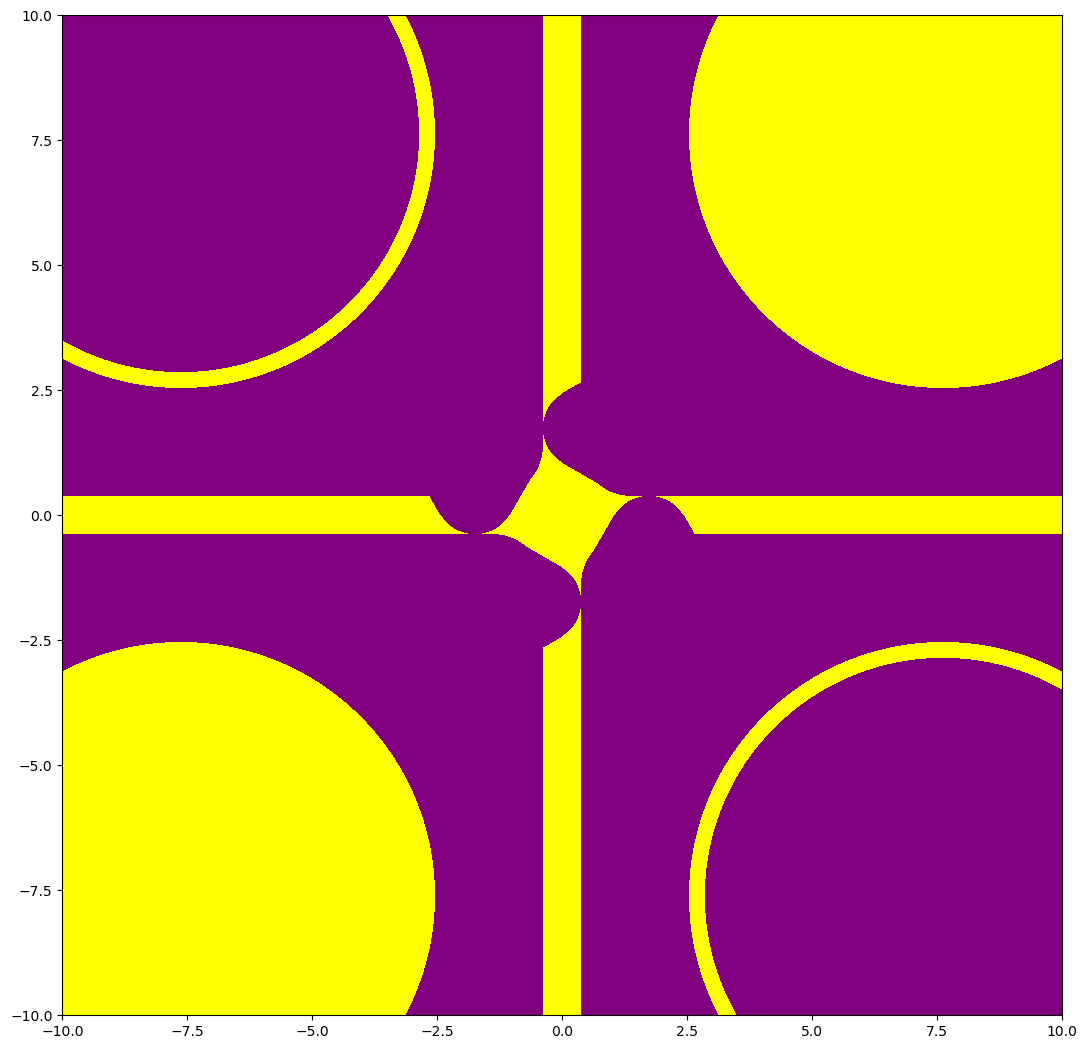

In [74]:
#testuniverse.plot(width=(700,700),
#        basis='xy',
#        colors=colormap,
#        origin=(0.,0.,200),
#        color_by='material',
#        pixels=(1000,1000))

In [ ]:
#testuniverse.plot(width=(700,650),
#        basis='xz',
#        colors=colormap,
#        origin=(0.,0.,220),
#        color_by='material',
#        pixels=(1000,1000))

In [ ]:
geo = openmc.Geometry()
geo.root_universe = testuniverse
#geo.remove_redundant_surfaces()
#geo.export_to_xml()

In [ ]:
geo.export_to_xml()

In [ ]:
geo.get_all_cells()

In [ ]:
plots = openmc.Plots()

plot = openmc.Plot(name='detail-zoneIA-IIA-lower1')
plot.origin=(215, 0, 10.0)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIA-main')
plot.origin=(215, 0, 23.0)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIIA-upper1')
plot.origin=(215, 0, 435)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIA-upper1')
plot.origin=(215, 0, 420)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIIA-upper2')
plot.origin=(215, 0, 437)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIA-upper2')
plot.origin=(215, 0, 439)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIIA-upper3')
plot.origin=(215, 0, 440)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIA-upper3')
plot.origin=(215, 0, 448)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIIA-upper4')
plot.origin=(215, 0, 442)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-IIA-lower1')
plot.origin=(0.0, 0, 10.0)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-main')
plot.origin=(0, 0, 23.0)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIIA-upper1')
plot.origin=(0, 0, 435)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-upper1')
plot.origin=(0, 0, 420)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIIA-upper2')
plot.origin=(0, 0, 437)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-upper2')
plot.origin=(0, 0, 439)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIIA-upper3')
plot.origin=(0, 0, 440)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-upper3')
plot.origin=(0, 0, 448)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIIA-upper4')
plot.origin=(0, 0, 442)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='core-xz-detail-upper')
plot.origin=(215, 0, 440)
plot.width=(100, 100)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xz'
plots.append(plot)

plot = openmc.Plot(name='full-core-xz')
plot.origin=(0, 0, 200)
plot.width=(700, 700)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xz'
plots.append(plot)

plots.export_to_xml()